In [136]:
import warnings
warnings.filterwarnings(action="ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as f
from glob import glob
%matplotlib inline

In [4]:
# 한글 폰트 문제 해결
import platform

from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~') 


# 차트 축 <- 음수 부호 지원
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

### 1. 지역이라고 시작되는 모든 파일 리턴후 데이터 프레임 변환

In [9]:
files = glob('../data/지역*.xls')

tmp_row = []
for file in files :
    tmp = pd.read_excel(file, header=2)
    tmp_row.append(tmp)
tmp_row

[       지역                   상호                          주소      상표  \
 0   서울특별시               오렌지주유소        서울 강동구 성안로 102 (성내동)   SK에너지   
 1   서울특별시               구천면주유소       서울 강동구 구천면로 357 (암사동)  현대오일뱅크   
 2   서울특별시       GS칼텍스㈜직영 신월주유소      서울 강동구 양재대로 1323 (성내동)   GS칼텍스   
 3   서울특별시                광성주유소       서울 강동구 올림픽로 673 (천호동)   S-OIL   
 4   서울특별시  (주)소모에너지엔테크놀러지성내주유소       서울 강동구 올림픽로 578 (성내동)   GS칼텍스   
 5   서울특별시      (주)퍼스트오일 코알라주유소   서울특별시 강동구  올림픽로 556 (성내동)   S-OIL   
 6   서울특별시         알이디씨(주)천동주유소   서울특별시 강동구  천호대로 987 (천호동)  현대오일뱅크   
 7   서울특별시             sk해뜨는주유소    서울특별시 강동구  상일로 132 (강일동)   SK에너지   
 8   서울특별시       대성석유(주)직영길동주유소      서울 강동구 천호대로 1168 (둔촌동)   GS칼텍스   
 9   서울특별시              방아다리주유소        서울 강동구 동남로 811 (명일동)   SK에너지   
 10  서울특별시   SK네트웍스㈜암사주유소(self)       서울 강동구 올림픽로 749 (암사동)   SK에너지   
 11  서울특별시       (주)삼표에너지 고덕주유소         서울 강동구 고덕로 39 (암사동)   GS칼텍스   
 12  서울특별시   CJ대한통운(주)직영 천호점주유소         서울 강동구 천중로 67 (천호동)  현대오일뱅크   
 13  서

In [109]:
oil_station = pd.concat(tmp_row)
oil_station.head()

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,서울특별시,오렌지주유소,서울 강동구 성안로 102 (성내동),SK에너지,02-484-6165,N,-,1554,1354,997
1,서울특별시,구천면주유소,서울 강동구 구천면로 357 (암사동),현대오일뱅크,02-441-0536,N,-,1556,1355,-
2,서울특별시,GS칼텍스㈜직영 신월주유소,서울 강동구 양재대로 1323 (성내동),GS칼텍스,02-475-2600,N,1855,1559,1349,1000
3,서울특별시,광성주유소,서울 강동구 올림픽로 673 (천호동),S-OIL,02-470-5133,N,-,1578,1388,1100
4,서울특별시,(주)소모에너지엔테크놀러지성내주유소,서울 강동구 올림픽로 578 (성내동),GS칼텍스,02-479-3838,Y,-,1588,1388,-


### 2. 휘발유를 대상으로 분석
- 상호, 주소, 휘발유, 셀프여부, 상표로 rename
- oil_store, address, price, self_y_n, company

In [110]:
oil_station_subset = pd.DataFrame({'oil_store' : oil_station['상호'],
                                   'address' : oil_station['주소'],
                                   'price' : oil_station['휘발유'],
                                   'self_y_n' : oil_station['셀프여부'],
                                   'company' : oil_station['상표']})
oil_station_subset.head()

,oil_store,address,price,self_y_n,company
0,오렌지주유소,서울 강동구 성안로 102 (성내동),1554,N,SK에너지
1,구천면주유소,서울 강동구 구천면로 357 (암사동),1556,N,현대오일뱅크
2,GS칼텍스㈜직영 신월주유소,서울 강동구 양재대로 1323 (성내동),1559,N,GS칼텍스
3,광성주유소,서울 강동구 올림픽로 673 (천호동),1578,N,S-OIL
4,(주)소모에너지엔테크놀러지성내주유소,서울 강동구 올림픽로 578 (성내동),1588,Y,GS칼텍스


### 3. 구별 주유소 가격을 조사하기 위한 파생변수 생성(direct)

In [111]:
oil_station_subset['direct'] = [address.split()[1] for address in oil_station_subset['address']]
oil_station_subset.head()

,oil_store,address,price,self_y_n,company,direct
0,오렌지주유소,서울 강동구 성안로 102 (성내동),1554,N,SK에너지,강동구
1,구천면주유소,서울 강동구 구천면로 357 (암사동),1556,N,현대오일뱅크,강동구
2,GS칼텍스㈜직영 신월주유소,서울 강동구 양재대로 1323 (성내동),1559,N,GS칼텍스,강동구
3,광성주유소,서울 강동구 올림픽로 673 (천호동),1578,N,S-OIL,강동구
4,(주)소모에너지엔테크놀러지성내주유소,서울 강동구 올림픽로 578 (성내동),1588,Y,GS칼텍스,강동구


### 4. 구별정보 확인(unique()사용)
- 서울특별시 --> 성동구
- 특별시 --> 도봉구

In [112]:
oil_station_subset['direct'].unique()

array(['강동구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '서울특별시', '성북구',
       '송파구', '양천구', '영등포구', '강북구', '용산구', '은평구', '종로구', '중구', '중랑구',
       '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구', '특별시'],
      dtype=object)

In [113]:
oil_station_subset.loc[oil_station_subset['direct'] == '서울특별시', 'direct'] = '성동구'
oil_station_subset.loc[oil_station_subset['direct'] == '특별시', 'direct'] = '도봉구'

In [114]:
oil_station_subset['direct'].unique()

array(['강동구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '강북구', '용산구', '은평구', '종로구', '중구', '중랑구', '강서구',
       '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구'], dtype=object)

### 5. 가격정보 확인 (- 들어있음) 후, 가격 정보가 기입되지 않은 주유소는 제거
- 컬럼 타입을 숫자형으로 변경



In [115]:
oil_station_subset = oil_station_subset[oil_station_subset['price'] != '-']

In [116]:
oil_station_subset['price'] = [int(price) for price in oil_station_subset['price']]
oil_station_subset

,oil_store,address,price,self_y_n,company,direct
0,오렌지주유소,서울 강동구 성안로 102 (성내동),1554,N,SK에너지,강동구
1,구천면주유소,서울 강동구 구천면로 357 (암사동),1556,N,현대오일뱅크,강동구
2,GS칼텍스㈜직영 신월주유소,서울 강동구 양재대로 1323 (성내동),1559,N,GS칼텍스,강동구
3,광성주유소,서울 강동구 올림픽로 673 (천호동),1578,N,S-OIL,강동구
4,(주)소모에너지엔테크놀러지성내주유소,서울 강동구 올림픽로 578 (성내동),1588,Y,GS칼텍스,강동구
...,...,...,...,...,...,...
15,대성산업(주)신창주유소,서울 도봉구 덕릉로 267 (창동),1548,N,GS칼텍스,도봉구
16,도담주유소,서울특별시 도봉구 도봉로 941 (도봉동),1559,N,SK에너지,도봉구
17,제일주유소,서울 도봉구 해등로3길 86 (창동),1598,N,S-OIL,도봉구
18,sk네트웍스 영신주유소,서울특별시 도봉구 방학로 151 (방학동 671-2),1639,N,SK에너지,도봉구


### 6. 인덱스를 새롭게 정의(reset_index)
- 인덱스열을 제거


In [117]:
oil_station_subset.reset_index(inplace=True)
oil_station_subset

,index,oil_store,address,price,self_y_n,company,direct
0,0,오렌지주유소,서울 강동구 성안로 102 (성내동),1554,N,SK에너지,강동구
1,1,구천면주유소,서울 강동구 구천면로 357 (암사동),1556,N,현대오일뱅크,강동구
2,2,GS칼텍스㈜직영 신월주유소,서울 강동구 양재대로 1323 (성내동),1559,N,GS칼텍스,강동구
3,3,광성주유소,서울 강동구 올림픽로 673 (천호동),1578,N,S-OIL,강동구
4,4,(주)소모에너지엔테크놀러지성내주유소,서울 강동구 올림픽로 578 (성내동),1588,Y,GS칼텍스,강동구
...,...,...,...,...,...,...,...
482,15,대성산업(주)신창주유소,서울 도봉구 덕릉로 267 (창동),1548,N,GS칼텍스,도봉구
483,16,도담주유소,서울특별시 도봉구 도봉로 941 (도봉동),1559,N,SK에너지,도봉구
484,17,제일주유소,서울 도봉구 해등로3길 86 (창동),1598,N,S-OIL,도봉구
485,18,sk네트웍스 영신주유소,서울특별시 도봉구 방학로 151 (방학동 671-2),1639,N,SK에너지,도봉구


### 7. 박스플롯을 이용한 셀프여부 비교 시각화

<Figure size 432x288 with 0 Axes>

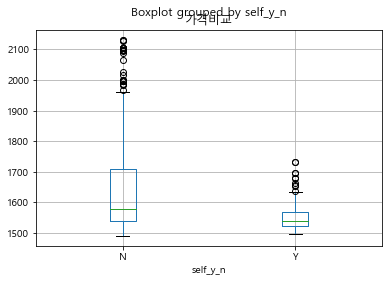

In [120]:
fig = plt.figure()

oil_station_subset.boxplot(column='price', by='self_y_n')
plt.title('가격비교')

plt.show()
plt.close()

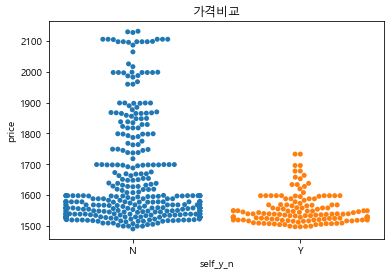

In [123]:
fig = plt.figure()

sns.swarmplot(x='self_y_n', y='price', data=oil_station_subset)
plt.title('가격비교')

plt.show()
plt.close()

### 8. 회사별 가격 시각화

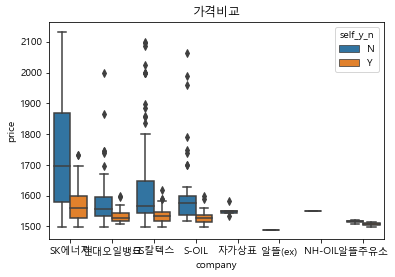

In [126]:
fig = plt.figure()

sns.boxplot(x='company', y='price', data=oil_station_subset, hue='self_y_n')
plt.title('가격비교')

plt.show()
plt.close()

### 9. 구별 휘발유 평균가격 확인

In [129]:
#conda install -c conda-forge googlemaps

import json
import googlemaps

In [133]:
direct_pivot = pd.pivot_table(oil_station_subset, index='direct', values='price', aggfunc=np.mean)
direct_pivot.head()

,price
direct,
강동구,1656.722222
강북구,1534.333333
강서구,1576.428571
관악구,1603.055556
광진구,1569.333333


In [134]:
geo_str = json.load(open('../data/02. skorea_municipalities_geo_simple.json', encoding='utf-8'))
geo_str

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': '강동구',
   'properties': {'code': '11250',
    'name': '강동구',
    'name_eng': 'Gangdong-gu',
    'base_year': '2013'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[127.11519584981606, 37.557533180704915],
      [127.16683184366129, 37.57672487388627],
      [127.18408792330152, 37.55814280369575],
      [127.16530984307447, 37.54221851258693],
      [127.14672806823502, 37.51415680680291],
      [127.12123165719615, 37.52528270089],
      [127.1116764203608, 37.540669955324965],
      [127.11519584981606, 37.557533180704915]]]}},
  {'type': 'Feature',
   'id': '송파구',
   'properties': {'code': '11240',
    'name': '송파구',
    'name_eng': 'Songpa-gu',
    'base_year': '2013'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[127.0690698130372, 37.522279423505026],
      [127.10087519791962, 37.524841220167055],
      [127.1116764203608, 37.540669955324965],
      [127.12123165719615, 37.52528270089

In [138]:
# 획으로 구분되는 자도
map = f.Map(location=[37.55, 126.98], zoom_start=10.5)
f.Choropleth(geo_data = geo_str, 
             data = direct_pivot, 
             columns = [direct_pivot.index, 'price'],
             key_on = 'feature.id').add_to(map)
map